# Calibración de la Cámara usando OpenCV

## 0. Resumen
1. Patrón
2. Sacar fotos desde diferentes puntos de vista
3. Encontrar esquinas
4. Ecuaciones de proyección patrón->foto

\begin{equation}
s \begin{bmatrix}
u_i \\ v_i \\ 1
\end{bmatrix} =
\begin{bmatrix}
K
\end{bmatrix}
\begin{bmatrix}
R_k | t_k
\end{bmatrix}
\begin{bmatrix}
X_i \\ Y_i \\ Z_i \\ 1
\end{bmatrix}
\end{equation}

K: 5 (o 4) parámetros

R: 5 (o 9) parámetros

t: 3 parámetros

5. Hallar K, R_k, t_k y de yapa los coeficientes de distorsión.
6. Rectificar la imagen  
7. Bonus: dibujar en 3D  

## 1. Patrón

![](patron.png)



In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print("OpenCV version " + cv2.__version__)
print("Numpy version " + np.__version__)


OpenCV version 4.6.0
Numpy version 1.23.1


In [2]:
import glob

import PIL.ExifTags
import PIL.Image

# Fotos desde distintos puntos de vista

In [25]:
calib_fnames = glob.glob('./imagenes_tp/img_cal_set1/*')

mostrar_figuras = False

### Identificación de Esquinas, Encontrar Matriz de Cámara

In [1]:
size_chess_table = 28

In [26]:
def table_size():
    # Tamaño del tablero:
    ch_size = (8, 6)

    # Lista de los puntos que vamos a reconocer en el mundo
    # objp={(0,0,0), (1,0,0), (2,0,0) .... }
    # corresponden a las coordenadas en el tablero de ajedrez.
    objp = np.zeros((np.prod(ch_size), 3),  dtype=np.float32)
    objp[:, :2] = np.mgrid[0:ch_size[0], 0:ch_size[1]].T.reshape(-1, 2)
    objp = objp * size_chess_table
    
    return objp, ch_size

In [27]:


def calib(calib_fnames):
    # lista de todos los puntos que vamos a recolectar
    obj_points = list()
    img_points = list()
    objp, ch_size = table_size()
    
    ## Criterio de corte para el proceso iterativo de refinamientoi de esquinas.
    # Parar si iteramos maxCount veces o si las esquinas se mueven menos de epsilon
    maxCount = 30
    epsilon = 0.001
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_MAX_ITER, maxCount, epsilon)
    cb_flags = cv2.CALIB_CB_ADAPTIVE_THRESH  
    # cb_flags = cv2.CALIB_CB_FAST_CHECK

    #%matplotlib qt

    for image_fname in calib_fnames:
        print("Procesando: " + image_fname , end='... ')
        img = cv2.imread(image_fname)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # para subpixel solamente gray
        ret, corners = cv2.findChessboardCorners(img_gray, ch_size, flags=cb_flags)
        if ret:
            print('Encontramos esquinas!')
            obj_points.append(objp)
            print('Buscando esquinas en resolución subpixel', end='... ')
            corners_subp = cv2.cornerSubPix(img_gray, corners, (5, 5), (-1, -1), criteria)
            print('OK!')
            img_points.append(corners_subp)
            cv2.drawChessboardCorners(img, ch_size, corners_subp, ret)
            if mostrar_figuras:
                plt.figure()
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.show()

    return obj_points, img_points, img_gray, img

In [28]:
obj_points, img_points, img_gray, img = calib(calib_fnames)

Procesando: ./imagenes_tp/img_cal_set1/img_cal1.png... Encontramos esquinas!
Buscando esquinas en resolución subpixel... OK!
Procesando: ./imagenes_tp/img_cal_set1/img_cal14.png... Encontramos esquinas!
Buscando esquinas en resolución subpixel... OK!
Procesando: ./imagenes_tp/img_cal_set1/img_cal15.png... Encontramos esquinas!
Buscando esquinas en resolución subpixel... OK!
Procesando: ./imagenes_tp/img_cal_set1/img_cal2.png... Encontramos esquinas!
Buscando esquinas en resolución subpixel... OK!
Procesando: ./imagenes_tp/img_cal_set1/img_cal17.png... Encontramos esquinas!
Buscando esquinas en resolución subpixel... OK!
Procesando: ./imagenes_tp/img_cal_set1/img_cal16.png... Encontramos esquinas!
Buscando esquinas en resolución subpixel... OK!
Procesando: ./imagenes_tp/img_cal_set1/img_cal3.png... Encontramos esquinas!
Buscando esquinas en resolución subpixel... OK!
Procesando: ./imagenes_tp/img_cal_set1/img_cal7.png... Encontramos esquinas!
Buscando esquinas en resolución subpixel... 

## 5. Calibración
Listo con la identificación de puntos, ahora a calibrar


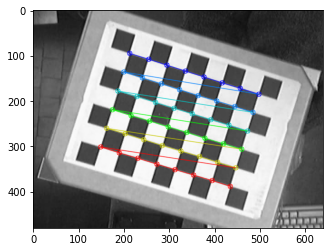

In [16]:
#img = cv2.imread(calib_fnames[idx])
#img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
h, w = img_gray.shape

plt.figure()
plt.imshow(img)
plt.show()

In [29]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points,

                                                   img_gray.shape[::-1], None, None,flags=cv2.CALIB_ZERO_TANGENT_DIST)

#distCoeffs – Output vector of distortion coefficients
#disotorsion tangencial p1=0,p2=0, puedo hacer cero a k2 y k3
dist[0][1]=0
dist[0][4]=0


print('Camera Matrix = ')
print(mtx)
print('Distortion Coefficients = ')
print(dist)

Camera Matrix = 
[[812.39918072   0.         316.72937723]
 [  0.         812.72585688 247.34172435]
 [  0.           0.           1.        ]]
Distortion Coefficients = 
[[0.02524597 0.         0.         0.         0.        ]]


### SET 1:

Camera Matrix = 
[[812.39918072   0.         316.72937723]
 [  0.         812.72585687 247.34172435]
 [  0.           0.           1.        ]]
Distortion Coefficients = 
[[0.02524597 0.         0.         0.         0.        ]]

In [18]:
pd.DataFrame(mtx).to_csv("./save_data/camara_matrix.csv", index=False)
pd.DataFrame(dist).to_csv("./save_data/dist_coefficients.csv", index=False)


# Calibrar Parametros Extrinsecos

In [30]:
calib_fnames_extr = glob.glob('./imagenes_tp/img_bloques/imgCalExtr.png')     

In [31]:

obj_points_extr, img_points_extr, img_gray_extr, img = calib(calib_fnames_extr)

Procesando: ./imagenes_tp/img_bloques/imgCalExtr.png... Encontramos esquinas!
Buscando esquinas en resolución subpixel... OK!


In [23]:
tvecs_extr


array([[-3.9103371],
       [-5.4846594],
       [25.1157339]])

In [33]:
ret_extr, rvecs_extr, tvecs_extr  = cv2.solvePnP(
    obj_points_extr[0],
    img_points_extr[0],
    mtx,
    dist,
    useExtrinsicGuess=False
)

#Converts a rotation matrix to a rotation vector
rotation = cv2.Rodrigues(rvecs_extr)[0]

print('Rotation = ', rotation)
print('Translation = ', tvecs_extr)

Rotation =  [[ 0.99922502 -0.00776181  0.03858902]
 [ 0.00790022  0.99996289 -0.00343565]
 [-0.03856092  0.00373785  0.99924926]]
Translation =  [[-109.48943883]
 [-153.57046326]
 [ 703.24054932]]


In [34]:
pd.DataFrame(tvecs_extr).to_csv("./save_data/translation_df.csv", index=False)
pd.DataFrame(rotation).to_csv("./save_data/rotation_df.csv", index=False)